# Notebook for Protein Predict and DownStream Analysis

This demo is for a quick demo of the prediction by the pre-trained DGAT model from Demo_Train_1.ipynb. 

We included the prediction on the Lymph Node dataset (ST).

Please first set the dir paths before running

In [1]:
import numpy as np

import scanpy as sc
import torch
import warnings
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from Model.dgat import GATEncoder, Decoder_Protein, Decoder_mRNA
from utils.Preprocessing import qc_control_cytassist, normalize, clean_protein_names, fill_genes, preprocess_ST
from Model.Train_and_Predict import train_and_evaluate_fold, protein_predict,get_activity

import random
import os
from muon import prot as pt

from utils.idk_utils import leiden_plot, find_edges,leiden_plot_scatter, leiden_plot_eva, plot_spatial_expression,merge_celltypes, infer_celltype_activity, plot_heatmap

warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

dataset_save_dir = './DGAT_training_datasets'
pyg_save_dir = './pyg_data' # Building a graph might take 5 mins or more (depends on the scale of the dataset).This directory is used to save the graph data in PyG format, which can be reused for prediction without rebuilding the graph.
model_save_dir = './DGAT_pretrained_models'# Directory to save the trained DGAT model. If you have a pre-trained model , please set this to the directory where the model is saved. 
pred_result_path = './DGAT_results' # Not necessary to set this directory, but if you want to save the prediction results, please set this to the directory where you want to save the results and uncomment the last line of each section.

hidden_dim=1024
dropout_rate=0.3



seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Load common genes and proteins for prediction

The current **common_gene_17434.txt** and **common_protein_31.txt** files are used for the prediction using pretrained model from Demo_Train_1.ipynb, which comes from the Tonsil1 after QC.  


In [2]:
with open("./resources/common_gene_17434.txt", "r") as f: 
    common_gene = [line.strip() for line in f]

with open("./resources/common_protein_31.txt", "r") as f: 
    common_protein = [line.strip() for line in f]

## Prediction on ST data

### Lymph Node

In [13]:
import tarfile
if not hasattr(tarfile, 'data_filter'):
    tarfile.data_filter = None 

import scanpy as sc
adata_LN = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_LN.var_names_make_unique()
celltypes = pd.read_csv("./resources/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("./resources/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)
obs_names = np.intersect1d(celltypes.index, adata_LN.obs_names)
adata_LN = adata_LN[obs_names]
celltypes = celltypes.loc[obs_names]
gc_annotation = gc_annotation.loc[obs_names]

adata_LN.obsm['celltype'] = celltypes
adata_LN.obsm['celltype'].columns = [x.replace('mean_spot_factors','') for x in adata_LN.obsm['celltype'].columns]
adata_LN.obsm['celltype_raw'] = adata_LN.obsm['celltype'].copy()
adata_LN.obsm['celltype'] = adata_LN.obsm['celltype'].divide(adata_LN.obsm['celltype'].sum(axis=1), axis=0)
adata_LN.obs['germinal_center'] = gc_annotation
adata_LN.obs['germinal_center'] = adata_LN.obs['germinal_center'].map({0: "Other", 1: "GC"})
df_celltype = merge_celltypes(adata_LN)
adata_LN.obsm['celltype_major'] = df_celltype

# Performs quality control and normalization on a Spatial Transcriptomics dataset.  
preprocess_ST(adata_LN)
# Ensures that the test dataset contains the same genes as the training dataset. Fills missing genes in the test data with zeros.  
adata_LN = fill_genes(adata_LN, common_gene)


Sample lost 0 genes, 17434 in total


In [14]:
# Predict Protein Expression from ST Data
pdata_LN = protein_predict(adata_LN,common_gene, common_protein, model_save_dir, pyg_save_dir)

Creating or loading dataset
Loading preprocessed data for sample 'V1_Human_Lymph_Node' from './pyg_data/V1_Human_Lymph_Node_17434_spatial=6_testing.pth'
Dataset ready


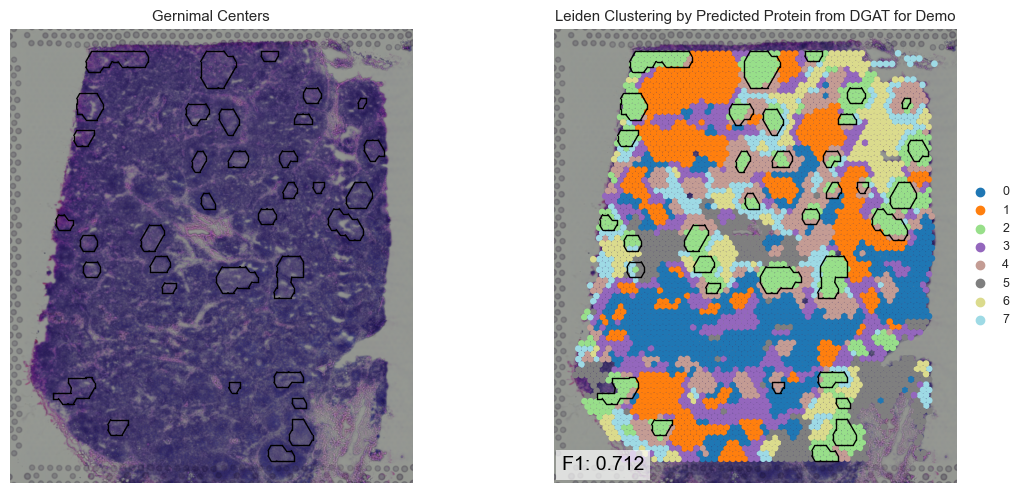

In [15]:
points, edges = find_edges(adata_LN)

pdata_LN = leiden_plot(pdata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 0.25,size = 1.7,title=f'Leiden Clustering by Predicted Protein from DGAT for Demo', palette = 'tab20',save_fig = False)

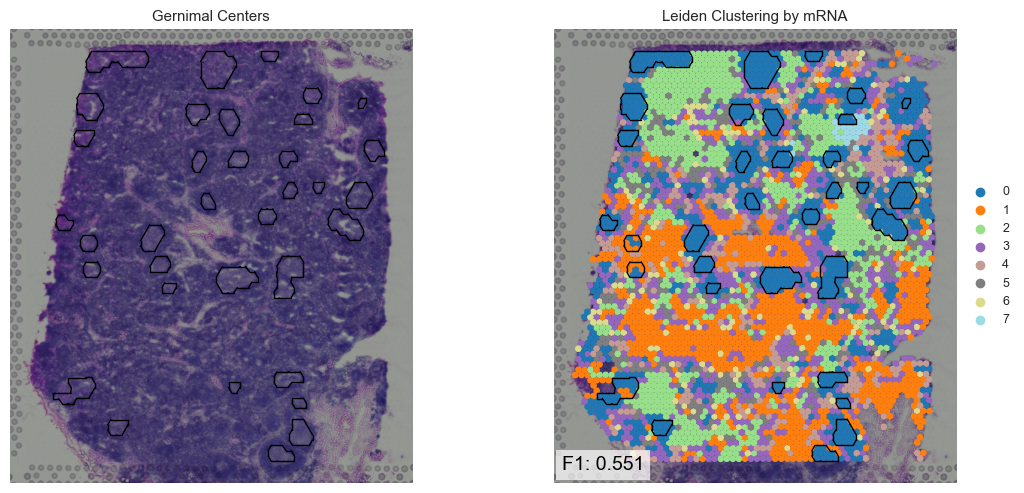

In [16]:
adata_LN = leiden_plot(adata_LN,n_neighbors = 10, points = points, edges = edges, plot_type = 'F1', resolution = 1.3,size = 1.7,title=f'Leiden Clustering by mRNA', palette = 'tab20',save_fig = False)


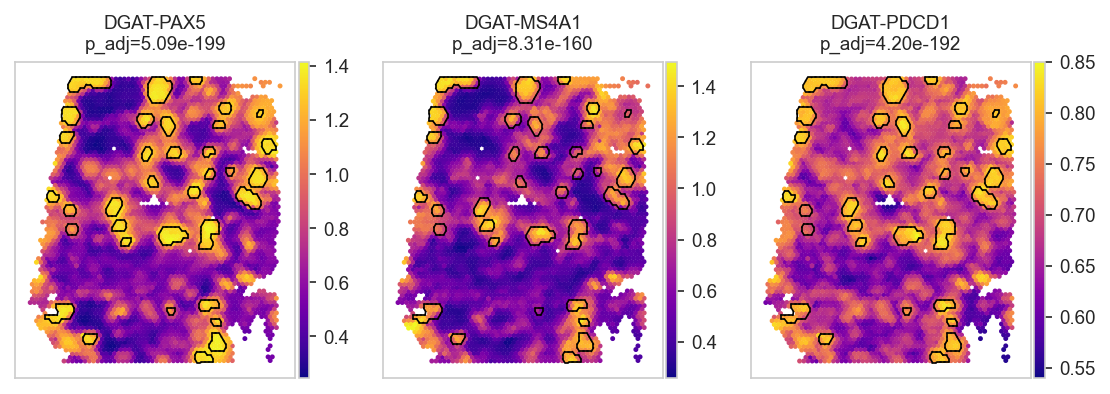

In [17]:
sc.tl.rank_genes_groups(pdata_LN, groupby='germinal_center', method="wilcoxon",alternative='greater')
plot_spatial_expression(pdata_LN, ['PAX5','MS4A1','PDCD1'], points, edges, 'DGAT')

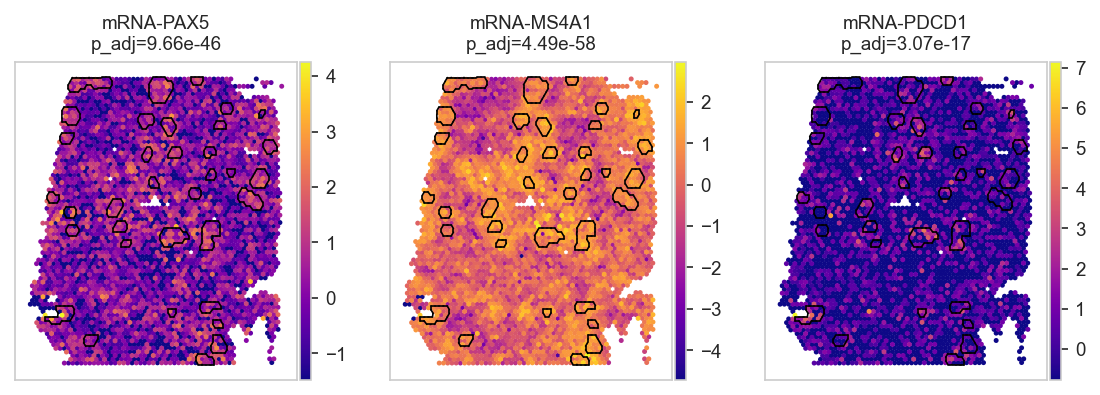

In [18]:
sc.tl.rank_genes_groups(adata_LN, groupby='germinal_center', method="wilcoxon",alternative='greater')
plot_spatial_expression(adata_LN, ['PAX5','MS4A1','PDCD1'], points, edges, 'mRNA')